<a href="https://colab.research.google.com/github/prachi0606/Agent-Based-Bitcoin-Trading-Simulation/blob/main/MLPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load Dataset
import pandas as pd

# Load the CSV file into a Pandas DataFrame
file_path = 'speakers_all.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [3]:
# Load Dataset
import os
import glob

AUDIO_DIR = "/content/drive/MyDrive/recordings"  # Update if needed

# Get a list of actual files in the recordings directory
existing_files = glob.glob(AUDIO_DIR + "*/*")  # Check all subdirectories

print(f"Total available files: {len(existing_files)}")
print("Example files:", existing_files[:10])

Total available files: 2138
Example files: ['/content/drive/MyDrive/recordings/hindko1.mp3', '/content/drive/MyDrive/recordings/hindi2.mp3', '/content/drive/MyDrive/recordings/hindi6.mp3', '/content/drive/MyDrive/recordings/hindi17.mp3', '/content/drive/MyDrive/recordings/hindi16.mp3', '/content/drive/MyDrive/recordings/hmong1.mp3', '/content/drive/MyDrive/recordings/icelandic1.mp3', '/content/drive/MyDrive/recordings/hungarian9.mp3', '/content/drive/MyDrive/recordings/hungarian8.mp3', '/content/drive/MyDrive/recordings/hungarian1.mp3']


In [4]:
# Feature Extraction

def extract_mfcc(file_path, max_len=100):
    if not os.path.exists(file_path):
        return None

    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc  # No transpose needed for CNN

features = []
labels = []
for _, row in df.iterrows():
    file_path = os.path.join(AUDIO_DIR, row["filename"] + ".mp3")
    mfcc_features = extract_mfcc(file_path)
    if mfcc_features is not None:
        features.append(mfcc_features)
        labels.append(row["native_language"])

In [5]:
# Data Preprocessing

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
features = np.array(features, dtype=np.float32)
labels_encoded = np.array(labels_encoded, dtype=np.int64)

# Reshape for CNN: (samples, 1, features, time-steps)
features = features[:, np.newaxis, :, :]

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [6]:
# Dataset and DataLoader

class AccentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AccentDataset(X_train_tensor, y_train_tensor)
test_dataset = AccentDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 3 * 25, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
# Model Training

num_classes = len(label_encoder.classes_)
model = CNNModel(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
num_epochs = 30
train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_acc = correct_train / total_train
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/30, Loss: 4.4041, Train Acc: 0.2170, Test Acc: 0.2780
Epoch 2/30, Loss: 3.9899, Train Acc: 0.2620, Test Acc: 0.2804
Epoch 3/30, Loss: 3.8666, Train Acc: 0.2591, Test Acc: 0.2780
Epoch 4/30, Loss: 3.8207, Train Acc: 0.2632, Test Acc: 0.2780
Epoch 5/30, Loss: 3.7743, Train Acc: 0.2649, Test Acc: 0.2734
Epoch 6/30, Loss: 3.6475, Train Acc: 0.2743, Test Acc: 0.2757
Epoch 7/30, Loss: 3.6716, Train Acc: 0.2713, Test Acc: 0.2734
Epoch 8/30, Loss: 3.6115, Train Acc: 0.2731, Test Acc: 0.2757
Epoch 9/30, Loss: 3.5810, Train Acc: 0.2737, Test Acc: 0.2780
Epoch 10/30, Loss: 3.4731, Train Acc: 0.2760, Test Acc: 0.2804
Epoch 11/30, Loss: 3.5076, Train Acc: 0.2807, Test Acc: 0.2780
Epoch 12/30, Loss: 3.4207, Train Acc: 0.2784, Test Acc: 0.2734
Epoch 13/30, Loss: 3.4327, Train Acc: 0.2731, Test Acc: 0.2734
Epoch 14/30, Loss: 3.3488, Train Acc: 0.2795, Test Acc: 0.2757
Epoch 15/30, Loss: 3.3819, Train Acc: 0.2848, Test Acc: 0.2827
Epoch 16/30, Loss: 3.2672, Train Acc: 0.2848, Test Acc: 0.2850
E

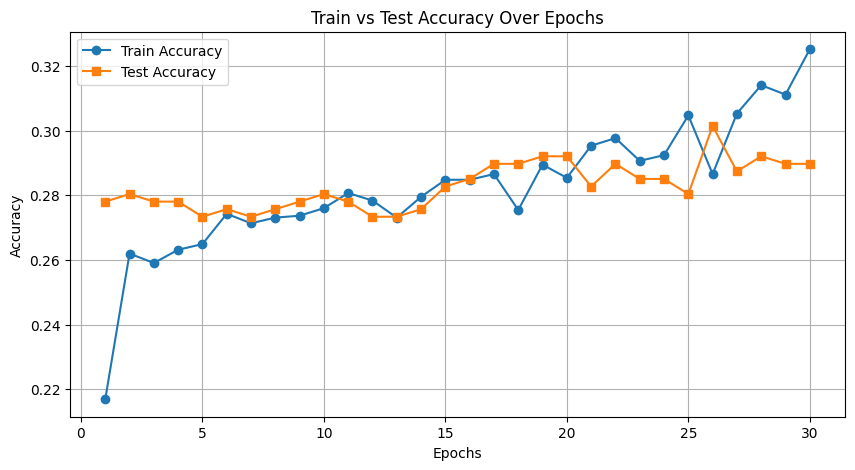

In [9]:
# Accuracy Plot

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Over Epochs")
plt.legend()
plt.grid()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/CNN_accuracy_plot.png", dpi=300)
plt.show()